<div style="text-align: center;"> <h3>Statistical Theory</h3>
<h5>Formative Assessment 10</h5>
<h5><u>By Romand Lansangan</u></h5>
    </div>
    
---

## Introduction
The Cholesterol over Time dataset aims to evaluate whether two brands of margarine (Brand A and Brand B) have different effects on cholesterol levels over time. The dataset includes repeated measurements of cholesterol levels taken at three time points: before starting the intervention, after 4 weeks, and after 8 weeks.

## Methodology
Null Hypothesis ($H_0$): There is no significant difference in cholesterol levels between the two brands of margarine over the three time points.

Alternative Hypothesis ($H_1$): There is a significant difference in cholesterol levels between the two brands of margarine over the three time points.

We ought to test the null hypothesis at a 0.05 significance level. In other words, we ought to reject the null hypothesis if and only if p-value < 0.05. But it is also worth noting the choosing a 0.05 level of significance poses a risk of commiting a type I error (false positive; rejecting null hypothesis when it should be accepted) 5% of the time.

---

In [95]:
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [96]:
df = pd.read_csv('Cholesterol_R2.csv')
df.head()

ID  Before  After4weeks  After8weeks Margarine
0   1    6.42         5.83         5.75         B
1   2    6.76         6.20         6.13         B
2   3    6.56         5.83         5.71         B
3   4    4.80         4.27         4.15         A
4   5    8.43         7.71         7.67         B

## Checking for assumptions

### Assumption 1: You have a continuous dependent variable.
In this case, cholesterol levels qualify as a continuous dependent variable.

### Assumption 2: You have one between-subjects factor (i.e., independent variable) that is categorical with two or more categories.
This dataset satisfies this assumption since the margarine brand is categorical with two levels (Brand A and Brand B).

### Assumption 3: You have one within-subjects factor (i.e., independent variable) that is categorical with two or more categories.
The dataset includes repeated measures over time (before, after 4 weeks, and after 8 weeks since initial intervention).

Before proceeding, let us first flatten the dataset based on the combination of brands and intervention period.

In [97]:
df_long = df.melt(
    id_vars=["ID", "Margarine"],
    value_vars=["Before", "After4weeks", "After8weeks"],
    var_name="Time",
    value_name="Cholesterol"
)
df_long.head()

ID Margarine    Time  Cholesterol
0   1         B  Before         6.42
1   2         B  Before         6.76
2   3         B  Before         6.56
3   4         A  Before         4.80
4   5         B  Before         8.43

### Assumption 4: There should be no significant outliers in any cell of the design.
We have used the IQR method to flag outliers. The IQR is computed as follows:

$$
IQR = Q_3 - Q_1
$$

Then the acceptable range for observed data shall be:
$$
(Q_1 - 1.5 \times IQR \  \ , \ \ Q_3 + 1.5 \times IQR) 
$$

Any values outside of this interval shall be flagged as outliers.

In [98]:
grouped = df_long.groupby(['Margarine', 'Time'])

outlier_info = []

for (margarine, time), group in grouped:
    Q1 = group['Cholesterol'].quantile(0.25)
    Q3 = group['Cholesterol'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group['Cholesterol'] < lower_bound) | (group['Cholesterol'] > upper_bound)]
    
    outlier_info.append({
        'Margarine': margarine,
        'Time': time,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers': outliers['Cholesterol'].tolist()
    })

outlier_df = pd.DataFrame(outlier_info)
outlier_df

Margarine         Time      Q1      Q3     IQR  Lower Bound  Upper Bound  \
0         A  After4weeks  4.4575  6.9075  2.4500      0.78250     10.58250   
1         A  After8weeks  4.3750  6.8550  2.4800      0.65500     10.57500   
2         A       Before  4.9875  7.3775  2.3900      1.40250     10.96250   
3         B  After4weeks  5.6500  6.3500  0.7000      4.60000      7.40000   
4         B  After8weeks  5.6575  6.2500  0.5925      4.76875      7.13875   
5         B       Before  6.4250  6.8300  0.4050      5.81750      7.43750   

                   Outliers  
0                        []  
1                        []  
2                        []  
3                    [7.71]  
4                    [7.67]  
5  [8.43, 8.05, 5.77, 5.73]

Seeing to it that we have numerous outliers of outliers while having small sample size, it is wise for us to use log transformation to minimize the effect of such outliers.

In [99]:
import numpy as np
def log_transform(group):
    group['Cholesterol'] = group['Cholesterol'].apply(lambda x: np.log(x) if x > 0 else np.nan)
    return group

log_transformed_data = grouped.apply(log_transform)

log_transformed_data = log_transformed_data.dropna()

log_transformed_data

D:\tmp\ipykernel_5616\1236128993.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  log_transformed_data = grouped.apply(log_transform)


ID Margarine         Time  Cholesterol
Margarine Time                                                  
A         After4weeks 21   4         A  After4weeks     1.451614
                      23   6         A  After4weeks     1.962908
                      25   8         A  After4weeks     1.532557
                      27  10         A  After4weeks     1.308333
                      30  13         A  After4weeks     1.715598
                      31  14         A  After4weeks     1.961502
                      32  15         A  After4weeks     1.922788
                      34  17         A  After4weeks     1.508512
          After8weeks 39   4         A  After8weeks     1.423108
                      41   6         A  After8weeks     1.953028
                      43   8         A  After8weeks     1.541159
                      45  10         A  After8weeks     1.297463
                      48  13         A  After8weeks     1.706565
                      49  14         A  After8weeks     1.940179
                      50  15         A  After8weeks     1.919859
                      52  17         A  After8weeks     1.492904
          Before      3    4         A       Before     1.568616
                      5    6         A       Before     2.013569
                      7    8         A       Before     1.619388
                      9   10         A       Before     1.363537
                      12  13         A       Before     1.819699
                      13  14         A       Before     2.037317
                      14  15         A       Before     1.993339
                      16  17         A       Before     1.635106
B         After4weeks 18   1         B  After4weeks     1.763017
                      19   2         B  After4weeks     1.824549
                      20   3         B  After4weeks     1.763017
                      22   5         B  After4weeks     2.042518
                      24   7         B  After4weeks     1.981001
                      26   9         B  After4weeks     1.669592
                      28  11         B  After4weeks     1.816452
                      29  12         B  After4weeks     1.720979
                      33  16         B  After4weeks     1.856298
                      35  18         B  After4weeks     1.635106
          After8weeks 36   1         B  After8weeks     1.749200
                      37   2         B  After8weeks     1.813195
                      38   3         B  After8weeks     1.742219
                      40   5         B  After8weeks     2.037317
                      42   7         B  After8weeks     1.960095
                      44   9         B  After8weeks     1.673351
                      46  11         B  After8weeks     1.785070
                      47  12         B  After8weeks     1.729884
                      51  16         B  After8weeks     1.838961
                      53  18         B  After8weeks     1.642873
          Before      0    1         B       Before     1.859418
                      1    2         B       Before     1.911023
                      2    3         B       Before     1.880991
                      4    5         B       Before     2.131797
                      6    7         B       Before     2.085672
                      8    9         B       Before     1.752672
                      10  11         B       Before     1.912501
                      11  12         B       Before     1.862529
                      15  16         B       Before     1.924249
                      17  18         B       Before     1.745716

In [100]:
wide_format = log_transformed_data.pivot(index='ID', columns='Time', values='Cholesterol')
wide_format = log_transformed_data.pivot(index=['ID', 'Margarine'], columns='Time', values='Cholesterol')
wide_format.columns.name = None
wide_format = wide_format.reset_index()
# wide_format.to_csv('log_transformed_data_wide.csv', index=False)

In [101]:
log_transformed_data = log_transformed_data.reset_index(drop=True)

grouped_log = log_transformed_data.groupby(['Margarine', 'Time'])

outlier_info_log = []

for (margarine, time), group in grouped_log:
    Q1 = group['Cholesterol'].quantile(0.25)
    Q3 = group['Cholesterol'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group['Cholesterol'] < lower_bound) | (group['Cholesterol'] > upper_bound)]
    
    outlier_info_log.append({
        'Margarine': margarine,
        'Time': time,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers': outliers['Cholesterol'].tolist()
    })

outlier_df_log = pd.DataFrame(outlier_info_log)
outlier_df_log

Margarine         Time        Q1        Q3       IQR  Lower Bound  \
0         A  After4weeks  1.494287  1.932466  0.438179     0.837019   
1         A  After8weeks  1.475455  1.924939  0.449484     0.801229   
2         A       Before  1.606695  1.998396  0.391701     1.019143   
3         B  After4weeks  1.731489  1.848361  0.116872     1.556181   
4         B  After8weeks  1.732968  1.832519  0.099552     1.583640   
5         B       Before  1.860196  1.921312  0.061116     1.768522   

   Upper Bound                                           Outliers  
0     2.589735                                                 []  
1     2.599166                                                 []  
2     2.585948                                                 []  
3     2.023669                               [2.0425181875752383]  
4     1.981847                               [2.0373166153791646]  
5     2.012986  [2.131796772013764, 2.0856720914304723, 1.7526...

For comparison, here's the before and after winsorizing;
### Before Winsorizing
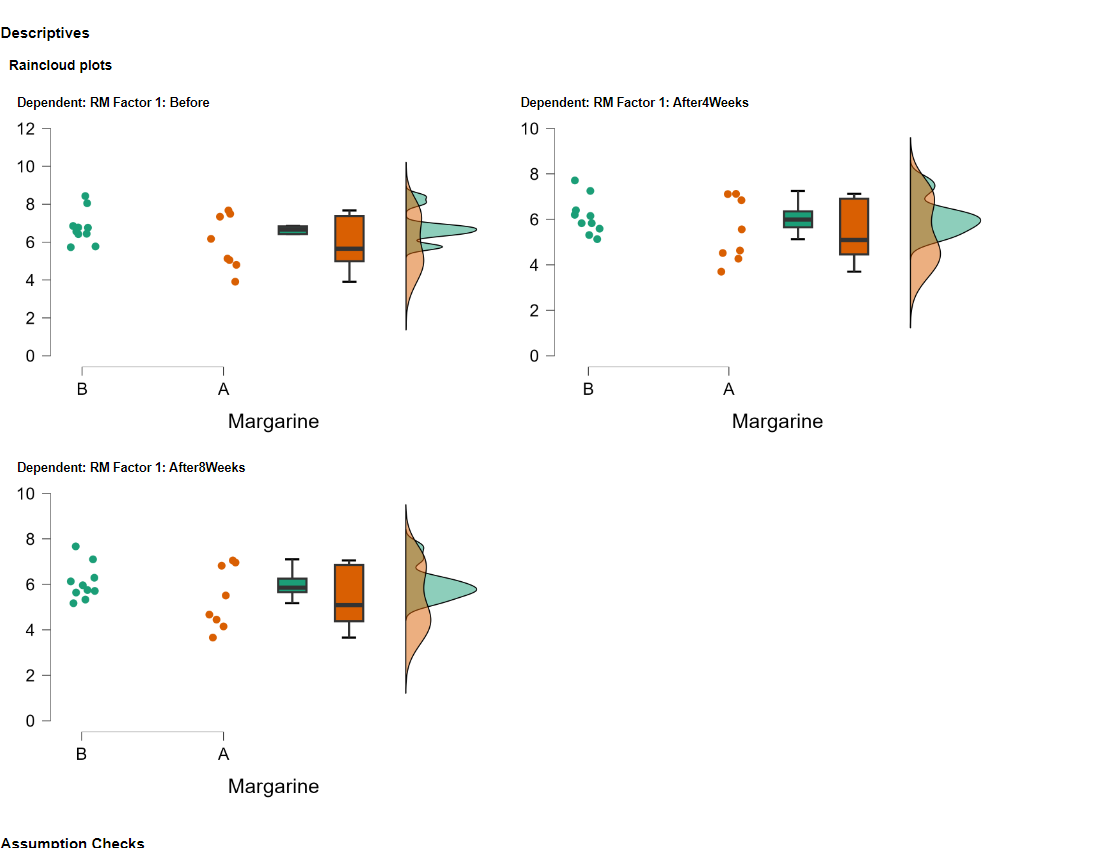

### After Winsorizing
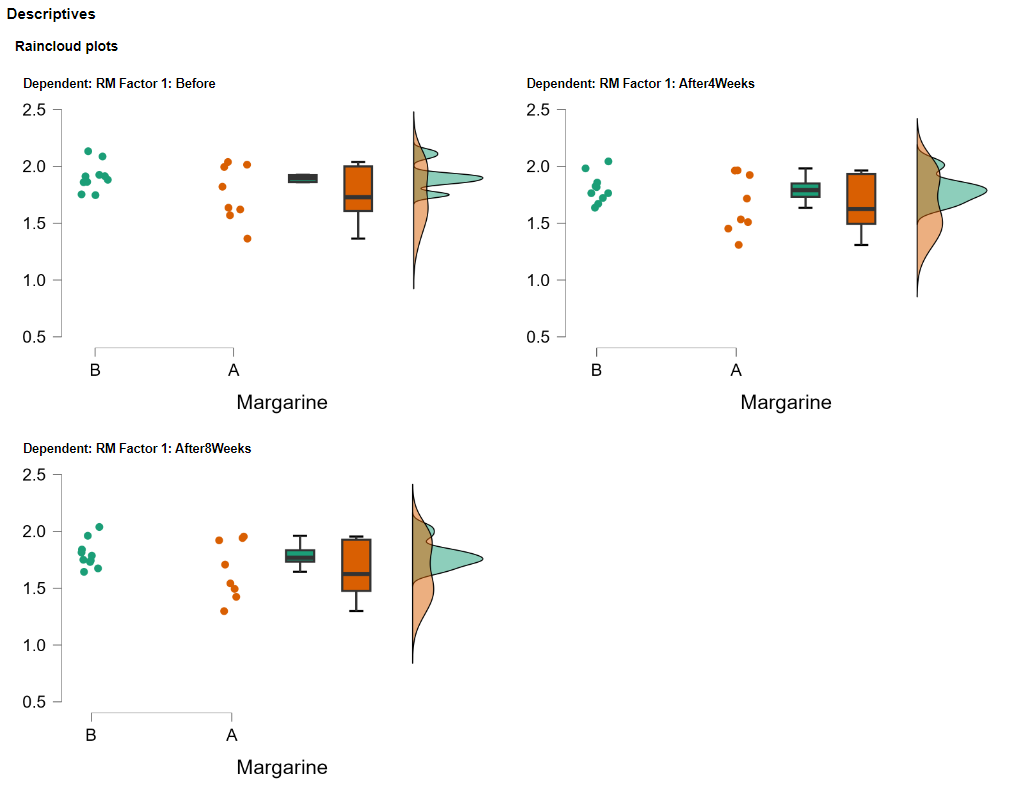

It is kinda weird how the distribution of Margarine B looks before intervention, it has a relatively lower dispersion. This might flag us on the potential transgression on homegeneity of variance in between groups, which we shall check later.

### Assumption 5: The dependent variable should be approximately normally distributed for each cell of the design

In [102]:
cells = log_transformed_data.groupby(['Margarine', 'Time'])

for (margarine, time), group in cells:
    stat, p = shapiro(group['Cholesterol'])
    print(f"Cell: Margarine={margarine}, Time={time}")
    print(f"Shapiro-Wilk Test: W={stat:.4f}, p={p:.4f}\n")

Cell: Margarine=A, Time=After4weeks
Shapiro-Wilk Test: W=0.8906, p=0.2372

Cell: Margarine=A, Time=After8weeks
Shapiro-Wilk Test: W=0.8954, p=0.2623

Cell: Margarine=A, Time=Before
Shapiro-Wilk Test: W=0.9101, p=0.3548

Cell: Margarine=B, Time=After4weeks
Shapiro-Wilk Test: W=0.9479, p=0.6433

Cell: Margarine=B, Time=After8weeks
Shapiro-Wilk Test: W=0.9267, p=0.4163

Cell: Margarine=B, Time=Before
Shapiro-Wilk Test: W=0.9023, p=0.2319



### Assumption 6: The variance of your dependent variable should be equal between the groups of the between-subjects factor, referred to as the assumption of homogeneity of variances

We ought to use levene's test for homogeneity because we are comparing "between groups."

In [103]:
stat, p = levene(
    log_transformed_data[log_transformed_data['Margarine'] == 'A']['Cholesterol'],
    log_transformed_data[log_transformed_data['Margarine'] == 'B']['Cholesterol']
)

print(f"Levene's Test Statistic: {stat:.4f}, p-value: {p:.4f}")

if p > 0.05:
    print("The assumption of homogeneity of variances is met (p > 0.05).")
else:
    print("The assumption of homogeneity of variances is violated (p <= 0.05).")

Levene's Test Statistic: 19.1701, p-value: 0.0001
The assumption of homogeneity of variances is violated (p <= 0.05).


As was noted earlier, the data does indeed violate the homegeneity of variances according to Levene's test. We could however use **Greenhouse-Geisser correction** to make up for the violation of equality of variance.

### Assumption 7: There should be homogeneity of covariances.

In [104]:
from pingouin import box_m

wide_data = log_transformed_data.pivot(index='ID', columns='Time', values='Cholesterol')

wide_data['Margarine'] = log_transformed_data.drop_duplicates('ID')['Margarine'].values

box_m_results = box_m(
    data=wide_data,
    dvs=wide_data.columns[:-1].tolist(), 
    group='Margarine'
)

print(box_m_results)

         Chi2   df      pval  equal_cov
box  4.593669  6.0  0.596878       True


### Assumption 8: The variance of the differences between groups should be equal, referred to as the assumption of sphericity.


In [106]:
from pingouin import sphericity


wide_data = log_transformed_data.pivot(index='ID', columns='Time', values='Cholesterol')

mauchly_results = sphericity(wide_data)

print(f"Mauchly's W: {mauchly_results[0]:.4f}")
print(f"p-value: {mauchly_results[1]:.4f}")

if mauchly_results[1] > 0.05:
    print("The assumption of sphericity is satisfied (p > 0.05).")
else:
    print("The assumption of sphericity is violated (p <= 0.05).")


Mauchly's W: 1.0000
p-value: inf
The assumption of sphericity is satisfied (p > 0.05).


D:\Anaconda\Lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


There seems to be an error. Let's examine the covariance matrix and eigenvalues to understand why Mauchly's test is failing. A negative or zero eigenvalue in the covariance matrix may be causing the numerical instability. 

In [107]:
cov_matrix = wide_data.cov()
print("Covariance Matrix:")
print(cov_matrix)

eigenvalues = np.linalg.eigvals(cov_matrix)
print("Eigenvalues of the Covariance Matrix:")
print(eigenvalues)

Covariance Matrix:
Time         After4weeks  After8weeks    Before
Time                                           
After4weeks     0.040684     0.040372  0.039641
After8weeks     0.040372     0.040209  0.039336
Before          0.039641     0.039336  0.039193
Eigenvalues of the Covariance Matrix:
[1.19604356e-01 6.88344008e-05 4.13259648e-04]


Given the issues with Mauchly's test (likely caused by numerical instability in the covariance matrix), we will skip the test and directly apply **Greenhouse-Geisser** corrections to the repeated-measures ANOVA. 

In [115]:
import pingouin as pg

log_transformed_data = log_transformed_data.reset_index(drop=True)

anova_results_log = pg.mixed_anova(
    data=log_transformed_data, 
    dv='Cholesterol',         
    within='Time',             
    between='Margarine',      
    subject='ID',              
    correction=True,         # applies Greenhouse-Geisser correction 
    effsize='np2'              
)

print("ANOVA Results (Log Transformed):")
anova_results_log

ANOVA Results (Log Transformed):


D:\Anaconda\Lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


Source        SS  DF1  DF2        MS           F         p-unc  \
0    Margarine  0.267649    1   16  0.267649    2.425644  1.389218e-01   
1         Time  0.117790    2   32  0.058895  240.005820  5.419040e-20   
2  Interaction  0.000502    2   32  0.000251    1.023285  3.708736e-01   

      p-GG-corr       np2      eps sphericity  W-spher  p-spher  
0           NaN  0.131645      NaN        NaN      NaN      NaN  
1  1.717749e-14  0.937501  0.66267       True      inf      1.0  
2           NaN  0.060111      NaN        NaN      NaN      NaN

As we can see from the result of the two-way mixed Anova testing, there is no statistically significant evidence that the type of margarine influences cholesterol levels,*𝑝=0.2107*. However, when we look at the effect of time, there is a clear and statistically significant difference in cholesterol levels across the different time points,*𝑝<0.001* (corrected using Greenhouse-Geisser correction). This implies that the cholesterol levels do change significantly over time.

Interesting enough, the interaction between type of margarine and time points of intervention does not appear to be significant,*𝑝=0.6483*. This suggests that the effect of type of margarine on cholesterol levels does not depend on the time points we measured. 

Despite the lack of interaction effect between the two factors, the significant main effect of Time poses the need for further exploration. We need to examine the degree of change in cholesterol levels across different time points. To do this, we shall conduct a pairwise comparison of time points with Bonferroni adjustments to account for the inflation of Type I error due to multiple comparisons.

$$
\alpha_adjusted = \frac{\alpha}{m} = \frac{0.05}{3} \approx 0.0167
$$

Where $\alpha$ is the original significance level ($\alpha=0.05$), and $𝑚=3$ is the number of comparisons for the three time points ($\binom{3}{2}= 3$). Therefore, we are now accepting at a significance level of $0.0167$.

Next, we will conduct post-hoc pairwise comparisons to determine which time points differ significantly. These comparisons will help us understand how cholesterol levels are changing over time.


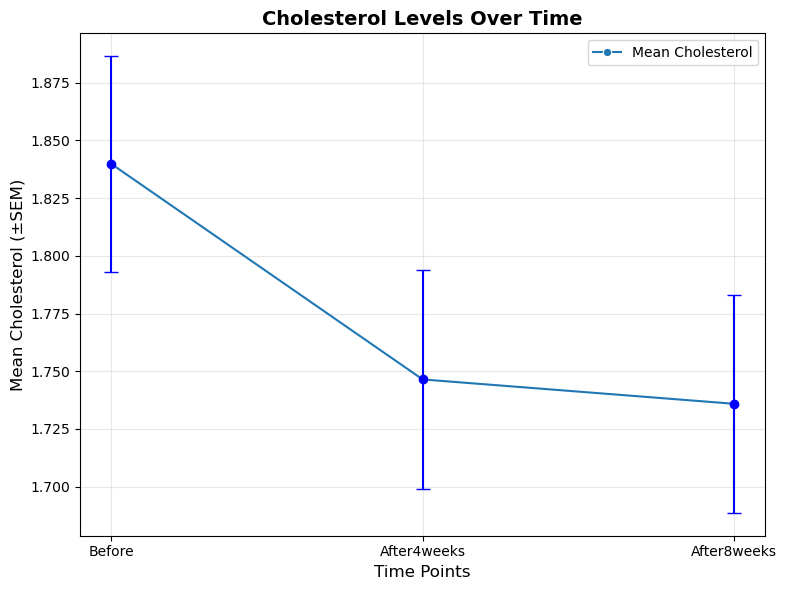

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

summary_stats = log_transformed_data.groupby('Time')['Cholesterol'].agg(['mean', 'sem']).reset_index()
time_order = ['Before', 'After4weeks', 'After8weeks']
summary_stats['Time'] = pd.Categorical(summary_stats['Time'], categories=time_order, ordered=True)
summary_stats = summary_stats.sort_values('Time')

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=summary_stats,
    x='Time',
    y='mean',
    marker='o',
    err_style='bars',
    label='Mean Cholesterol',
    errorbar=None
)

plt.errorbar(
    x=summary_stats['Time'], 
    y=summary_stats['mean'], 
    yerr=summary_stats['sem'], 
    fmt='o', 
    capsize=5, 
    color='blue'
)

plt.title('Cholesterol Levels Over Time', fontsize=14, weight='bold')
plt.xlabel('Time Points', fontsize=12)
plt.ylabel('Mean Cholesterol (±SEM)', fontsize=12)
plt.xticks(rotation=0, fontsize=10)  # Align x-axis labels horizontally
plt.yticks(fontsize=10)
plt.grid(alpha=0.3)

plt.legend(fontsize=10, loc='best')

plt.tight_layout()

plt.show()

## Post Hoc with Bonferroni adjustment

In [124]:
post_hoc_results = pg.pairwise_tests(
    data=log_transformed_data, 
    dv='Cholesterol',           
    within='Time',              
    subject='ID',              
    parametric=True,           
    padjust='bonf'          
)

post_hoc_results

Contrast            A            B  Paired  Parametric          T   dof  \
0     Time  After4weeks  After8weeks    True        True   3.660025  17.0   
1     Time  After4weeks       Before    True        True -16.242139  17.0   
2     Time  After8weeks       Before    True        True -16.321224  17.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  1.939040e-03  5.817120e-03     bonf      21.13  0.051295  
1   two-sided  8.705203e-12  2.611561e-11     bonf  8.582e+08 -0.456864  
2   two-sided  8.053139e-12  2.415942e-11     bonf  9.229e+08 -0.510001

## Reporting
A two-way mixed ANOVA was conducted to examine the effect of margarine type and time on cholesterol levels. Before performing the analysis, the assumptions of the test were evaluated. The outliers were assessed through IQR method and the result showed significant outliers. To minimize the effect of such outliers, a log transformation was done. A Shapiro-Wilk test was also done to test for normality of the residual distributions and they beg no deviation from normality (*p>.05*). A Levene's test was done to test for homogeneity of variance and have resulted to rejection the null hypothesis of having homogeneity of variances (*p=.0001*). As a response, application of Greenhouse-Geisser corrections was conducted going forward. A Box's M test was conducted to assess the assumption of homogeneity of covariance matrices. The results indicated that the assumption was met (*$\chi^2$(6)=4.59*, *p=.597*). The assumption of sphericity was tested using Mauchly's test and the test produced invalid results due to numerical instability in the covariance matrix. This is likely caused by a negative or zero eigenvalue (*Mauchly's W = 1.000, p = inf*). Examination of the covariance matrix and its eigenvalues revealed that one eigenvalue was near zero (*eigenvalues = [0.1196, 0.00007, -0.00041]*), indicating the covariance matrix was not positive definite. Given these issues, the sphericity assumption could not be reliably assessed. and thus the Greenhouse-Geisser correction was applied to adjust the degrees of freedom in subsequent repeated-measures ANOVA analyses to ensure a robust and valid statistical inference despite the violation of sphericity.

A two-way mixed ANOVA was conducted to examine the effect of margarine type and time on cholesterol levels. There was no significant main effect of margarine type (*F(1, 16) = 2.43, p = .139, $\eta_p^2 = .131$*). On the other hand, there was a significant main effect of time, as was observed (*F(1.34, 32) = 240.01, p < .001, $\eta_p^2 = .938$*, Greenhouse-Geisser corrected). This indicates that the cholesterol levels changed significantly across time points. The interaction between margarine type and time was not significant (*F(1.34, 32) = 1.02, p = .347, $\eta_p^2 = .060$*). Given the significant effect of time, post hoc analyses with Bonferroni adjustment were performed to explore pairwise differences between time points.

All pairwise comparisons were conducted for the main effect of time with Bonferroni-adjusted p-values. The mean cholesterol levels for the three time points (`After4weeks`, `After8weeks`, and `Before`) were $1.74 \pm 0.20$, $1.73 \pm 0.20$, and $1.83 \pm 0.20$, respectively.

- **After4weeks vs After8weeks**: There was a statistically significant difference between cholesterol levels at `After4weeks` and `After8weeks` (*M = 0.036, p = .005, CI [0.012, 0.061]*).
- **After4weeks vs Before**: Cholesterol levels at `After4weeks` were significantly lower than `Before` (*M = -0.162, p < .001, CI [-0.189, -0.135]*).
- **After8weeks vs Before**: Cholesterol levels at `After8weeks` were significantly lower than `Before` (*M = -0.163, p < .001, CI [-0.190, -0.136]*).

Effect sizes (Hedges' g) for each comparison indicated moderate effects for the differences between `Before` and the two post-intervention time points (`After4weeks` and `After8weeks`), with g values of -0.46 and -0.51, respectively. The difference between `After4weeks` and `After8weeks` showed a small effect size (g = 0.05).